# Final Report: Comparative Analysis of Residential Home Sales in East Hartford and West Hartford



## Introduction

### Background Info
Different areas have different price distributions and variability which may be a crucial factor in someone’s plans for the next few years of their life. Therefore, understanding the housing market and real estate trends is very important when potential homebuyers want to make informed decisions before buying. There are many ways to be more informed, ranging from official legislature setting a bar for how professional agents better serve consumers with their needs and interests in mind, to personal research that one does on the side.

### Project Question
Is there a difference in mean sale price of residential properties in two different towns, East Hartford and West Hartford, segmented by residential type?

### Data Set
We will be using the Real Estate Sales 2001-2020 GL data set from the Data.gov data catalog. It contains records about real estate sales over $2,000 in the US state of Connecticut between the years of 2001 to 2020, including information about the year of listing, town, assessed value, sale amount, property type, and residential type. 


## Preliminary Results

First we wrangle the data and plot it before doing our preliminary analysis

In [1]:
# loading in libraries
library(tidyverse)
library(tidymodels)
library(janitor)
library(infer)
library(patchwork)
options(repr.plot.width = 8, repr.plot.height =5) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Wrangling Dataset

In [2]:
# data set url
url <- "https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD"

# read data 
real_estate_data <- read_csv(url) |>
    clean_names()

head(real_estate_data)

Rows: 997213 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Date Recorded, Town, Address, Property Type, Residential Type, Non ...
dbl (5): Serial Number, List Year, Assessed Value, Sale Amount, Sales Ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type,non_use_code,assessor_remarks,opm_remarks,location
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500,325000,0.4630,Commercial,NA,NA,NA,NA,NA
20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000,430000,0.5883,Residential,Single Family,NA,NA,NA,NA
200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400,179900,0.7248,Residential,Condo,NA,NA,NA,NA
200243,2020,04/13/2021,Avon,111 NORTHINGTON DRIVE,619290,890000,0.6958,Residential,Single Family,NA,NA,NA,NA
200377,2020,07/02/2021,Avon,70 FAR HILLS DRIVE,862330,1447500,0.5957,Residential,Single Family,NA,NA,NA,NA
200109,2020,12/09/2020,Avon,57 FAR HILLS DRIVE,847520,1250000,0.6780,Residential,Single Family,NA,NA,NA,NA


In [3]:
# keeping only relevant columns and filtering out houses sold before 2017 to decrease the effect of inflation
real_estate_selected <- real_estate_data |>
    select(town, list_year, assessed_value, sale_amount, residential_type) %>%
    filter(!is.na(list_year), !is.na(sale_amount), !is.na(residential_type), !is.na(town), !is.na(assessed_value), list_year >= 2017)
head(real_estate_selected)

# keeping only the two towns of interest
filtered_real_estate <- real_estate_selected %>%
    filter(town == "West Hartford" | town == "East Hartford")
head(filtered_real_estate)

town,list_year,assessed_value,sale_amount,residential_type
<chr>,<dbl>,<dbl>,<dbl>,<chr>
Ashford,2020,253000,430000,Single Family
Avon,2020,130400,179900,Condo
Avon,2020,619290,890000,Single Family
Avon,2020,862330,1447500,Single Family
Avon,2020,847520,1250000,Single Family
Berlin,2020,234200,130000,Two Family


town,list_year,assessed_value,sale_amount,residential_type
<chr>,<dbl>,<dbl>,<dbl>,<chr>
West Hartford,2020,216580,305000,Single Family
West Hartford,2020,181720,327900,Single Family
West Hartford,2020,166670,305000,Condo
East Hartford,2020,87380,235000,Single Family
East Hartford,2020,73340,180000,Single Family
East Hartford,2020,99730,164000,Single Family


In [4]:
# Looking at the number of homes sold in the two towns we are interested in
diff_town <- filtered_real_estate %>%
    group_by(town, residential_type) %>%
    summarize(n = n())
diff_town

`summarise()` has grouped output by 'town'. You can override using the
`.groups` argument.


town,residential_type,n
<chr>,<chr>,<int>
East Hartford,Condo,314
East Hartford,Four Family,33
East Hartford,Single Family,2528
East Hartford,Three Family,74
East Hartford,Two Family,216
West Hartford,Condo,747
West Hartford,Four Family,3
West Hartford,Single Family,3665
West Hartford,Three Family,60


Since we see that three and four family houses are not very common, we will remove them from our sample as they may be skewed or not provide a lot of insight. The rest of the housing types were sold quite frequently in both towns and have a reasonably sized number number of housing sales, so we should not have to worry about outliers and can continue on with the data.

In [5]:
# calculating some summary statistics about the population
real_estate_final <- filtered_real_estate %>%
    filter(residential_type == "Condo" | residential_type == "Single Family" | residential_type == "Two Family")

stats <- real_estate_final %>%
    group_by(town, residential_type) %>%
    summarize(mean_sale_amount = mean(sale_amount), 
              min_sale_amount = min(sale_amount), 
              max_sale_amount = max(sale_amount), 
              mean_year = mean(list_year), 
              min_year = min(list_year), 
              max_year = max(list_year), 
              n = n())
head(stats)

# Generating simpler statistics regardless of residential type for preliminary analysis
stats_simple <- real_estate_final %>%
    group_by(town) %>%
    summarize(mean_sale_amount = mean(sale_amount), median_year = median(list_year), n = n())

head(stats_simple)

`summarise()` has grouped output by 'town'. You can override using the
`.groups` argument.


town,residential_type,mean_sale_amount,min_sale_amount,max_sale_amount,mean_year,min_year,max_year,n
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
East Hartford,Condo,124937.7,3000,4500000,2018.742,2017,2020,314
East Hartford,Single Family,162864.7,1200,420000,2018.509,2017,2020,2528
East Hartford,Two Family,180050.0,20000,355000,2018.579,2017,2020,216
West Hartford,Condo,234574.5,9000,1625000,2018.600,2017,2020,747
West Hartford,Single Family,355614.3,5000,1700000,2018.604,2017,2020,3665
West Hartford,Two Family,340705.5,77500,565000,2018.686,2017,2020,194


town,mean_sale_amount,median_year,n
<chr>,<dbl>,<dbl>,<int>
East Hartford,160184.1,2019,3058
West Hartford,335356.1,2019,4606


#### Making the relavent plots for East and West Hartford

In [6]:
# Making histogram of East Hartford
options(repr.plot.width=15, repr.plot.height=6)
east_data <- real_estate_final %>%
    filter(town == "East Hartford") 

east_plot <- east_data%>%
    ggplot() +
    geom_histogram(aes(x = sale_amount), bins = 10000, color = "green") +
    labs(x = "Sale Amount ($)", y = "Frequency", title = "Distribution of East Hartford Sale Prices") +
    geom_vline(xintercept = 160184.1, colour="red") + 
    xlim(0, 1000000) + 
    theme(text = element_text(size = 12))

# Making histogram of West Hartford
west_data <- real_estate_final %>%
    filter(town == "West Hartford") 

west_plot <- west_data%>%
    ggplot() +
    geom_histogram(aes(x = sale_amount), bins = 10000, color = "blue") +
    labs(x = "Sale Amount ($)", y = "Frequency", title = "Distribution of West Hartford Sale Prices") +
    geom_vline(xintercept = 335356.1, colour="red") + 
    xlim(0, 1000000) +
    theme(text = element_text(size = 12))

In [7]:
# separate the real_estate_final by residence types
single_family <- real_estate_final |>
    filter(residential_type == "Single Family")

two_family <- real_estate_final |>
    filter(residential_type == "Two Family") 

condo <- real_estate_final |>
    filter(residential_type == "Condo")

In [8]:
# making boxplots for each residential type
options(repr.plot.width=9, repr.plot.height=6)
single_family_boxplot <- single_family |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for single family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

two_family_boxplot <- two_family |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for two family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

condo_boxplot <- condo |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for condo housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

#### Displaying the plots

In [ ]:
# Displaying the histograms
# Because of the kernal constantly dying when trying to run these cells, we are loading in a PNG of the histogram (this is the exact same histogram the code would of loaded)

# options(warn= -1)
# (east_plot | west_plot)


### Distribution of East Hartford Sale Prices


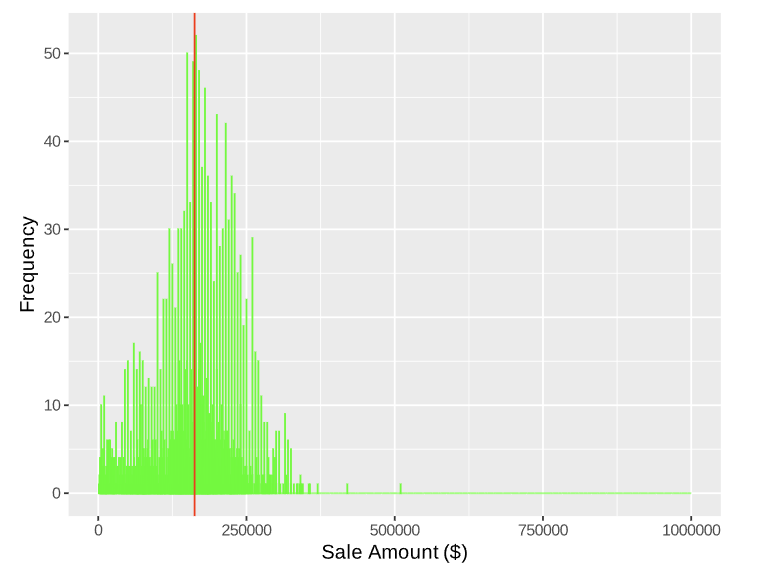


### Distribution of West Hartford Sale Prices


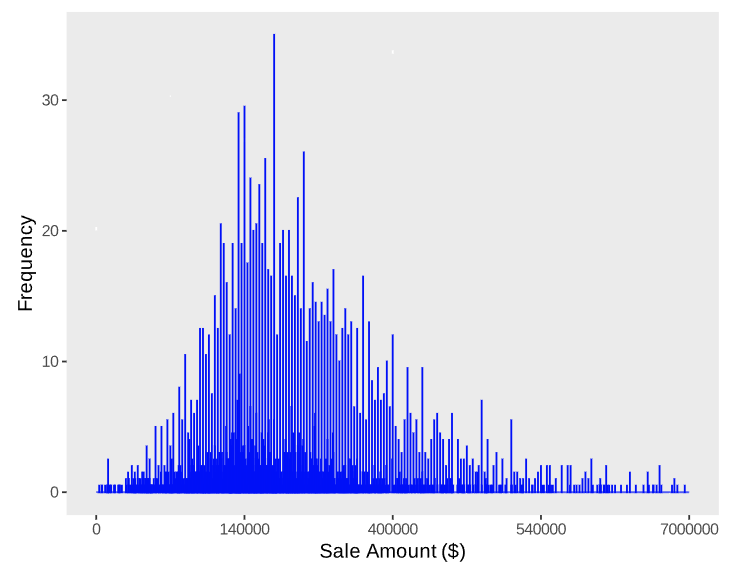

In [ ]:
# Displaying the boxplots

(single_family_boxplot | two_family_boxplot | condo_boxplot)

Just looking at the boxplots and histograms it is clear there are a few outliers in our data when it comes to the sale price. To prevent this we will be filtering our sale amounts to get rid of sales that occur above $Q3 + 3*IQ$ and below $Q1 - 3*IQ$ for each respective housing type and then replotting it to get a better idea of how our data looks.

In [ ]:
# Filtering out the outliers and making the new boxplots

options(repr.plot.width=18, repr.plot.height=6)
Q_single <- quantile(single_family$sale_amount, probs = c(0.25, 0.75), na.rm = FALSE)
iqr_single <- IQR(single_family$sale_amount)
single_no_outlier <- subset(single_family, single_family$sale_amount > (Q_single[1]-1.5*iqr_single) & single_family$sale_amount < (Q_single[2]+1.5*iqr_single))

single_family_boxplot_no_outlier <- single_no_outlier |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for single family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

Q_two <- quantile(two_family$sale_amount, probs = c(0.25, 0.75), na.rm = FALSE)
iqr_two <- IQR(two_family$sale_amount)
two_no_outlier <- subset(two_family, two_family$sale_amount > (Q_two[1]-1.5*iqr_two) & two_family$sale_amount < (Q_two[2]+1.5*iqr_two))

two_family_boxplot_no_outlier <- two_no_outlier |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for two family housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

Q_condo <- quantile(condo$sale_amount, probs = c(0.25, 0.75), na.rm = FALSE)
iqr_condo <- IQR(condo$sale_amount)
condo_no_outlier <- subset(condo, condo$sale_amount > (Q_condo[1]-1.5*iqr_condo) & condo$sale_amount < (Q_condo[2]+1.5*iqr_condo))

condo_boxplot_no_outlier <- condo_no_outlier |>
    ggplot(aes(x = town, y = sale_amount, fill = town)) +
        geom_boxplot() +
        xlab("Town") +
        ylab("Sale amount ($)") +
        ggtitle("Boxplot for condo housing") +
        theme(text = element_text(size = 16)) +
        scale_y_continuous(labels = comma) + 
        guides(fill = "none")

In [ ]:
# Displaying the new boxplots with no outliers

(single_family_boxplot_no_outlier | two_family_boxplot_no_outlier | condo_boxplot_no_outlier)

### Preliminary Analysis
After looking at the mean sale price and plots for East and West Hartford, while we see that West Hartford does seem to have a higher mean, it may not be enough to immediately assume that West Hartford always has a higher mean in housing sales price. Especially when it comes to bigger numbers such as the amount of money required to buy a house, it is better to be statistically sure of your analysis rather than just taking a single snapshot as the whole picture for granted. Especially because we cannot be sure with the outliers that are in the sample.


## Methods: Plan

Hypothesis: Since both East and West Hartford both reside within Hartford we expect the median sale price of each half of the city to be the same. We will be testing this theory for the 3 most popular residential types of housing within Hartford, condos, single family houses, and two family houses. 

In other words: 
Let Se be the median sales price of housing in East Hartford and let Sw be the median sales price of housing in West Hartford.  Our null hypothesis $H_0: Se - Sw = 0$ versus $H_A: Se - Sw \neq 0$.

We will be testing our hypothesis at a $\alpha = 0.001$ significance level. Which means if our P-value does not fall below 0.001, we would fail to reject $H_0$. The reason for picking such a low value of $\alpha$ is because just from our preliminary data exploratory analysis, we can already see Hartford has on average a higher sale price. That way if we were to accept $H_0$ we would be more sure that we are unlikely to make a type 1 error.

In order to calculate our P-value we will use both bootstrapping and reshuffling to generate more copies of the sample in order to calculate P on. After generating our samples we will calculate the required summary statistics in our case being the difference in median sales price. This gives us our null distribution of which we can plot, or go straight into calculating P with. This will be done using the infer package. After we get our P value we can either reject or accept the null hypothesis depending if it's above or under our 0.001 significance level.


## Perform hypothesis testing via permutation

As seen above our boxplot visualizes that East Hartford and West Hartford sale prices are different. To further investigate this we will now conduct our hypothesis test comparing mean sale prices.
$H_0: Se - Sw = 0$ 

$H_A: Se - Sw \neq 0$.

In [ ]:
# Firstly, we obtain our test statistic 
obs_diff_in_means <- real_estate_final |>
specify(formula =  sale_amount ~ town) |>
calculate(stat="diff in means", order = c("East Hartford", "West Hartford"))

obs_diff_in_means

In [ ]:
# Now let's create our null distribution
null_diff_in_means <-
real_estate_final %>% 
    specify(formula = sale_amount ~ town) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("East Hartford", "West Hartford"))

# We will now visualize our null distribution with our test statistic
diff_in_means_plot <- null_diff_in_means %>%
    visualize(bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "both") + 
    xlab("Difference in means")

diff_in_means_plot

From our plot we observe our test statistic is highly unlikely under the null hypothesis. This indicates we are likely to have a low p-value, very close to or equal to zero.

In [ ]:
# And finally obtain the p-value
p_value <- null_diff_in_means |>
get_p_value(obs_stat = obs_diff_in_means, direction = "both")

p_value

From our visulization we saw that our test statistic is very unlikely under the null model. This unlikelihood is further conveyed by our low $p$-value, which prompts us to reject the our null hypothesis, that there is no differnce between mean sale prices of properties in East Hartford and West Hartford, at a 5% significance level. Rejecting the null hypothesis puts us at risk of committing a type I error. After rejecting the null hypothesis a type I error would occur if and only if the true difference of between mean sale amounts in East Hartford and West Hartford is zero.

Now let's create a 95% cofidence interval for the true differnce in mean sale prices between East Hartford and West Hartford

## Obtain a 95% confidence interval (Bootstrap approach)

In [ ]:
# obtain 95% confidence interval using bootstrapping
diff_in_means_bootstrap_dist <- real_estate_final |>
specify(formula = sale_amount ~ town) |>
generate(type = "bootstrap", reps = 1000) |>
calculate(stat = "diff in means", order = c("East Hartford", "West Hartford"))

diff_in_means_ci <- diff_in_means_bootstrap_dist |>
get_confidence_interval( level = 0.95, type = "percentile")


diff_in_means_ci

From our bootstrapped confidence interval we are 95% confident that the true differnce in mean sale prices between East Hartford and West Hartford is between -181117.4 and -168796.8

Let's now compare these results to a theory based approach. For our theory based approach we will be conducting a two sampled t test, to do this we need to apply CLT. We can apply CLT as we have a large enough sample size (n = ??), our sample is randomly drawn from the population and our sample values our independent.

## Two sampled t test

In [ ]:
# We will be conducting our t test using t.test from the tidy package
sampling_dist_means <- real_estate_final |>
rep_sample_n(reps = 10000, size = 7) |>
group_by(replicate) |>
summarise(town = town,
    sale_mean = mean(sale_amount))

east <- sampling_dist_means |>
filter(town == "East Hartford")
west <- sampling_dist_means |>
filter(town == "West Hartford")

t_test <- 
    tidy(
        t.test(x = east$sale_mean,
               y = west$sale_mean,
               alternative = "two.sided")) 

In [ ]:
# Let's obtain our p-value from our t test
t_test$p.value

We observe that our $p$-value obtained from our t test is the same as the p value obtained earlier. Now let's compare our confidence intervals.

In [ ]:
confidence_interval <- data.frame(ci_lower = t_test$conf.low, ci_upper = t_test$conf.high)
confidence_interval

Our 95% confidence intervals are quite different, we can observe that our t test confidence interval is more narrow. This could be a result of our original sample in our bootstrapping approach, since we were generating bootstrapped samples from such a large sample it would make sense that there is a lot of variability between bootstrapped samples hence our confidence interval is wider.

In context of our question it appears the t test is better than the other as it's confidence interval is much narrower, implying that it is "more confident." However applying CLT is not very efficent as it required us to generate the sampling distribution which is not always plausible in real life. Furthermore, using CLT requires assumption of our data, whereas bootstrapping does not. However, from our results we can observe how much our values were influenced by our original sample in bootstrapping. This could be an major issue in bootstrapping. If an original sample is not representative of the population, then bootstrapping will provide inaccurate results. Overall we believe both methods are equally as trustworthy in the right situations. However we have that one method may be 'better' than the other in different contexes.

## References

Real Estate Sales 2001-2020 GL. data.ct.gov, 9 Aug. 2023. Data.gov, 

    https://catalog.data.gov/dataset/real-estate-sales-2001-2018.
Real Estate Agents As a Source of Information for Home Buyers - HOUSTON - 1977 - Journal of Consumer Affairs - Wiley Online Library. 

    https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-6606.1977.tb00600.x. 
    
    Accessed 4 Nov. 2023.
    
Harnaga, Brandon J. Another Housing Bubble? A Review of Historical Indicators and Analysis of the Current State of the U.S. Residential Real Estate Market. May 2021. soar.suny.edu, 
    
    https://soar.suny.edu/handle/20.500.12648/1885.
